# Spam Classification

The objective of it is to generate a model capable to classify a email as spam or not spam.

The dataset used was from http://www2.aueb.gr/users/ion/data/enron-spam/

#### Imports

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text as txt
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import email
from email.message import EmailMessage
from email.parser import BytesParser, Parser
from email.policy import default
import ast
import re
import datetime

[nltk_data] Downloading package stopwords to /home/phrc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/phrc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Functions

In [2]:
def createDf(path):
    """
    Read all email files and convert to a dataframe

    Parameters
    ----------
    path: str
        Path to a root directory to be read

    Returns
    ----------
    dataframe
        a dataframe with x columns based in all emails properties
    """
    os.chdir(path)
    data = []
    for root, dirs, files in os.walk(path):
         for file in files:
            with open(os.path.join(root, file), "rb") as openFile:
                dictTemp = {}
                try:
                    message = email.message_from_binary_file(openFile, policy=default)
                    #Parser(policy=default).parsestr(openFile.read())
                    dictTemp['file'] = openFile.name
                    for key in message.keys():
                        dictTemp[key.lower()] = message[key]
                    dictTemp['messageType'] = message.get_content_type()
                    body = message.get_body()
                    if body['content-type'].maintype == 'text':
                        if body['content-type'].subtype == 'plain':
                            dictTemp['messageStr'] = str(body.get_content())
                        elif body['content-type'].subtype == 'html':
                            dictTemp['messageStr'] = str(body)
                    elif body['content-type'].content_type in 'multipart':
                        dictTemp['messageStr'] = str(body.get_body(preferencelist=('html')))
                    dictTemp['parseError'] = False                 
                except:
                    dictTemp['parseError'] = True
                data.append(dictTemp)
    df = pd.DataFrame(data)
    return df

def emailTextCleanner(text):
    """
    Remove:
        Html Tags
        Email headers
        Ponctuation
        break lines and tabs
    
    And convert the string to lower case 

    Parameters
    ----------
    text: str

    Returns
    ----------
    str
    """
    try:
        text = str(text).lower()
        text = text.replace("\\", " ")
        text = text.replace("\x01", " ")
        clean = re.compile('charset.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('content-.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('received: from.*\n')
        text = re.sub(clean, '', text)
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', str(text))
        clean = re.compile('['+string.punctuation+']')
        text = re.sub(clean, ' ', text)
        clean = re.compile("[0-9]")
        text = re.sub(clean, " ", text)
        toRemove = frozenset(['xpriority','nbsp', 'enron','xmsmailpriority','xmimeole','mimeole','cc','enrons'])
        pattern = re.compile(r'\b(' + r'|'.join(toRemove) + r')\b\s*')
        text = pattern.sub(' ', text)
 
        return text
    except:
        print(type(text))
        return ""
    #text = TextBlob(text)
    #text = str(text.correct())
    
def lemmatizeList(words):
    """
    Lemmatize a list of string

    Parameters
    ----------
    words: list of str

    Returns
    ----------
    list of str
    """
    lem = WordNetLemmatizer()
    for i in range(len(words)):
        words[i] = lem.lemmatize(words[i], 'v')
        words[i] = lem.lemmatize(words[i], 'n')
    return words

def revomeWordsWithOneCharacter(words):
    return list(filter(lambda x : len(x) > 1, words))

def removeDigits(words):
    return list(filter(lambda x : x.isdigit() == False, words))

def createPlotLenghtDist(col, df):
    fig = plt.figure(figsize = (18,6))
    grid = plt.GridSpec(1,4, wspace =0.8)
    histPlt = fig.add_subplot(grid[0,0:2])
    boxPlt1 = fig.add_subplot(grid[0,2])
    boxPlt2 = fig.add_subplot(grid[0,3])

    histPlt.hist(
        [
            df[df['isSpam'] == True][col], 
            df[df['isSpam'] == False][col]
        ], 
        np.linspace(0, df[col].quantile(0.75), 30), 
        density = True, 
        label=['Spam', 'Ham']
    ) 
    histPlt.legend(loc='upper right')

    boxPlt1.boxplot(
        (
             df[df['isSpam'] == True][col], 
             df[df['isSpam'] == False][col] 
        ), 
        labels = ('Spam', 'Ham')
    )

    boxPlt2.boxplot(
        (
            df[(df['isSpam'] == True) & (df[col] < df[col].quantile(0.75))][col], 
            df[(df['isSpam'] == False) & (df[col] < df[col].quantile(0.75))][col] 
        ), 
        labels = ('Spam', 'Ham')
    )

    plt.show()

def plot20MostWord(counter):
    df = pd.DataFrame(list(dict(counter).items()))
    df.columns = ['word', 'occur'] 
    totalOcurr = df['occur'].sum()
    df['freq'] = df['occur'] / totalOcurr  
    df = df.sort_values(by='freq', ascending=False)
    df = df.reset_index(drop=True)
    df['freqAcum'] = df['freq'].cumsum()


    fig = plt.figure(figsize = (18,12))
    grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
    pltLine = fig.add_subplot(grid[0:2,0])
    pltBar = fig.add_subplot(grid[2:4,0:2])
    pltTable = fig.add_subplot(grid[0:2,1])

    pltLine.plot(df['freqAcum'], range(len(df)))
    pltLine.set_ylabel('Number of Words')
    pltLine.set_xlabel('Acumulative Frequence')
    pltLine.set_title('Line Graph of acumulative frequence')
    pltLine.grid(True)


    dfTWord = df.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

    pltTable.table(cellText=dfTWord.values, rowLabels= dfTWord.index, colLabels = dfTWord.columns, loc='best')
    pltTable.axis('off')
    pltTable.set_title('Table of acumulative frequence')



    pltBar.bar(df.head(20)['word'], df.head(20)['freq'])
    pltBar.set_title('20 Most Used word')

    yPos = np.arange(20)
    pltBar.set_xticklabels(df.head(20)["word"], rotation=60)
    pltBar.set_xticks(yPos)


    plt.show()
    
def totalUniqueWordsPlot(l1,l2,l3):
    fig = plt.figure(figsize = (18,6))
    grid = plt.GridSpec(1,2, wspace =0.2)
    pltBar = fig.add_subplot(grid[0,0])
    pltText = fig.add_subplot(grid[0,1])

    pltBar.bar(
        ['Total unique words', 'Spam unique words', 'Ham unique words'], 
        [l1,l2,l3], 
        align='center'
    )

    textWords = ['Total unique words:              {}'.format(l1), 
                 'Total spam unique words:    {}'.format(l2), 
                 'Total ham unique words:      {}'.format(l3)]



    pltText.text(x=0, y=0.5, s = '\n'.join(textWords), fontsize = 18) 
    pltText.axis('off')
    plt.show()

## Dataset generation

In [3]:
root = '/home/phrc/Python Project/Spam Email Classifier/'
#root = '/Users/phrc/Documents/Projects/pythonProject/SpamEmailClassifier/'

spamPath = root+'emails/spam/'
hamPath = root+'emails/ham/'


dfSpam = createDf(spamPath)
dfHam = createDf(hamPath)

# Dataset Visualisation and Preparation 

## Dataset Size

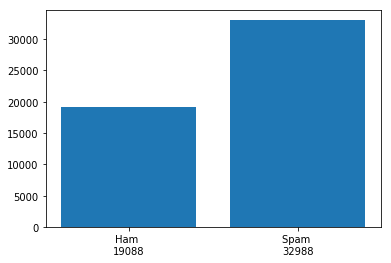

In [4]:
plt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
plt.xticks(np.arange(2), ('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))

plt.show();

## Dataset Spam Columns Analyse

In [5]:
dfSpamDesc = dfSpam.describe(include=['object']).T
print('Total of Spam attributes {}'.format(len(dfSpamDesc)))
n = len(dfSpam) * 0.75 
dfSpamDesc[dfSpamDesc['count'] > n].head(300)

Total of Spam attributes 465


,count,unique,top,freq
content-type,32835,7616,"text/html; charset=""iso-8859-7""",12553
date,32572,30490,"Tue, 19 Jan 2038 11:14:07 +0800",52
file,32988,32988,/home/phrc/Python Project/Spam Email Classifie...,1
from,32957,27895,COMPUTRON <khatun@emirates.net.ae>,347
messageStr,29849,27602,Call out Gouranga be happy!!!\nGouranga Gouran...,79
messageType,32965,8,text/html,16715
mime-version,31915,448,1.0,30943
subject,32831,20625,,613
to,32380,5254,paliourg@iit.demokritos.gr,7068


## Dataset Ham Columns Analyse

In [6]:
dfHamDesc = dfHam.describe(include=['object']).T
print('Total of Ham attributes {}'.format(len(dfHamDesc)))
n = len(dfHam) * 0.75 
dfHamDesc[dfHamDesc['count']> n].head(300)

Total of Ham attributes 19


,count,unique,top,freq
content-transfer-encoding,19079,2,7bit,18363
content-type,19079,2,"text/plain; charset=""us-ascii""",17818
date,19088,18173,"Tue, 21 Aug 2001 14:57:01 -0700",5
file,19088,19088,/home/phrc/Python Project/Spam Email Classifie...,1
from,19088,2349,pete.davis@enron.com,1395
message-id,19088,19088,<24303776.1075863311908.JavaMail.evans@thyme>,1
messageStr,19079,18401,\nI am pleased to announce the formation of th...,5
messageType,19079,1,text/plain,19079
mime-version,19079,1,1.0,19079
subject,19084,14679,Schedule Crawler: HourAhead Failure,343


## Parser Emails Error Analyse 

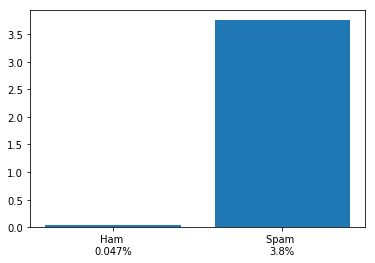

In [7]:
dfHamP = dfHam[dfHam['parseError'] == True]
dfSpamP = dfSpam[dfSpam['parseError'] == True]
hamFreq = (len(dfHamP) * 100 / len(dfHam))
spamFreq = (len(dfSpamP) * 100 / len(dfSpam))
plt.bar(np.arange(2), (hamFreq, spamFreq), align='center')
plt.xticks(np.arange(2), ('Ham \n{0:.2}%'.format(hamFreq), 'Spam \n{0:.2}%'.format(spamFreq)))

plt.show();

### -- Removing emails with parser problems 

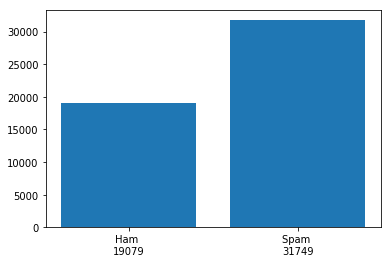

In [8]:
dfSpam = dfSpam[dfSpam['parseError'] == False]
dfHam = dfHam[dfHam['parseError'] == False]

plt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
plt.xticks(np.arange(2), ('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))

plt.show();

## Join Dataset and Remove unnescessary columns

In [9]:
dfSpam = dfSpam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to']]
dfHam = dfHam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to']]

dfSpam['isSpam'] = True
dfHam['isSpam'] = False

dfMaster = pd.concat([dfSpam, dfHam])
print('Total size of dataset {}'.format(len(dfMaster)))
dfMaster.head()

Total size of dataset 50828


,date,from,messageStr,messageType,subject,to,isSpam
0,"Fri, 24 Jun 2005 23:29:50 +0600",Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,True
1,"Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,True
3,"Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,True
4,"Sun, 03 Jul 2005 21:45:26 +0000",Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,True
5,"Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,True


## Check for Empty e-mail messages 

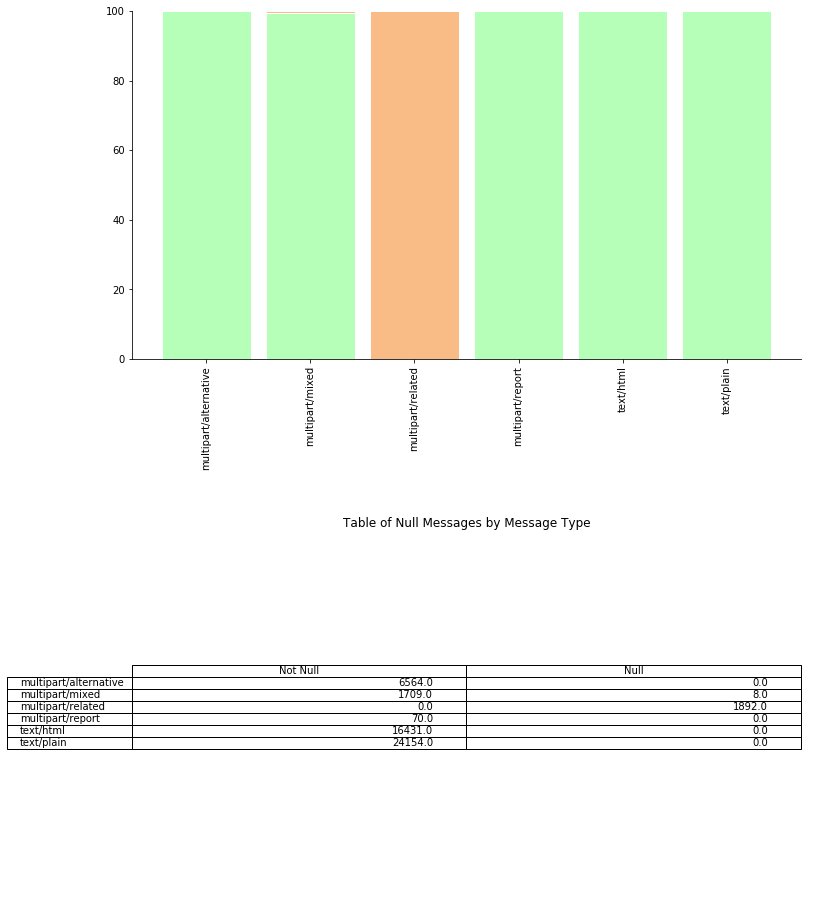

In [10]:
fig = plt.figure(figsize = (12,16))
grid = plt.GridSpec(2,3, wspace =0.3, hspace =0.5)
stackBar = fig.add_subplot(grid[0,0:3])
tableMsg = fig.add_subplot(grid[1,0:3])

dfMaster['msgIsNull'] = dfMaster['messageStr'].isnull()
dfGroup2 = dfMaster.groupby(['messageType', 'msgIsNull']).size()

dfG2 = dfGroup2.unstack()
dfG2 = dfG2.fillna(0)

dfMaster['msgIsNull'] = dfMaster['messageStr'].isnull()
dfGroup2 = dfMaster.groupby(['messageType', 'msgIsNull']).size()

dfG2 = dfGroup2.unstack().fillna(0)

totals = [i+j for i,j in zip(dfG2[False], dfG2[True])]
falseBars = [i / j * 100 for i,j in zip(dfG2[False], totals)]
trueBars = [i / j * 100 for i,j in zip(dfG2[True], totals)]

stackBar.bar(range(len(dfG2)), falseBars, color='#b5ffb9', edgecolor='white', width=0.85)
stackBar.bar(range(len(dfG2)), trueBars, bottom=falseBars, color='#f9bc86', edgecolor='white', width=0.85)

stackBar.set_xticks(range(len(dfG2)))
stackBar.set_xticklabels(dfG2.index.values, rotation='vertical')
stackBar.spines['top'].set_visible(False)
stackBar.spines['right'].set_visible(False)
stackBar.get_xaxis().tick_bottom()
stackBar.get_yaxis().tick_left()

tableMsg.table(cellText=dfG2.values, rowLabels= dfG2.index, colLabels = ['Not Null', 'Null'], loc='center')
tableMsg.axis('off')
tableMsg.set_title('Table of Null Messages by Message Type')

plt.show()

del dfMaster['msgIsNull']

## Remove Empty e-mail messages 

In [11]:
dfMaster = dfMaster[dfMaster['messageStr'].notnull()]

print('Total size of dataset: {}'.format(len(dfMaster[dfMaster['messageStr'].notnull()])))

Total size of dataset: 48928


## Dataset distribution by spam type

## -- Size

Spam    29849
Ham     19079
Name: isSpam, dtype: int64


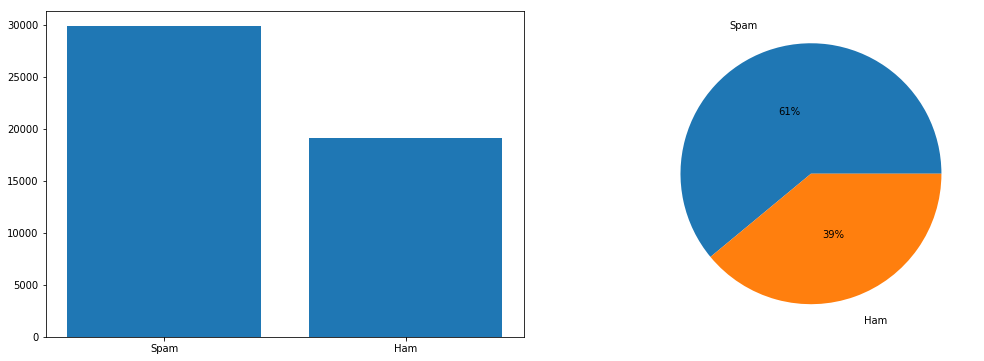

In [12]:
print(dfMaster['isSpam'].value_counts().rename({False: 'Ham', True: 'Spam'}))


fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])


barPlt.bar(
    ('Spam', 'Ham'), 
    [len(dfMaster[dfMaster['isSpam'] == True]), len(dfMaster[dfMaster['isSpam'] == False])], 
    align='center')
barPlt.set_xticks(np.arange(2), ['Spam', 'Ham'])


piePlt.pie(dfMaster['isSpam'].value_counts(), labels=['Spam', 'Ham'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

## -- Message Type

messageType            isSpam
multipart/alternative  True       6564
multipart/mixed        True       1709
multipart/report       True         70
text/html              True      16431
text/plain             False     19079
                       True       5075
dtype: int64


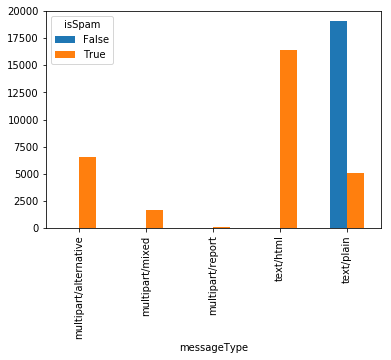

In [13]:
dfGroup = dfMaster.groupby(['messageType', 'isSpam']).size()
print(dfGroup)
dfGroup.unstack().plot(kind='bar', legend=True)

## -- Day Hour

In [14]:
#Convert Date to a date time object
dfMaster['date'] = dfMaster['date'].apply(lambda x : str(x)).apply(lambda x : None if x == 'nan' else datetime.datetime.strptime(x, '%a, %d %b %Y %H:%M:%S %z'))
#Create a Hour Column
dfMaster['hour'] = dfMaster['date'].apply(lambda x : None if x == None else x.hour)

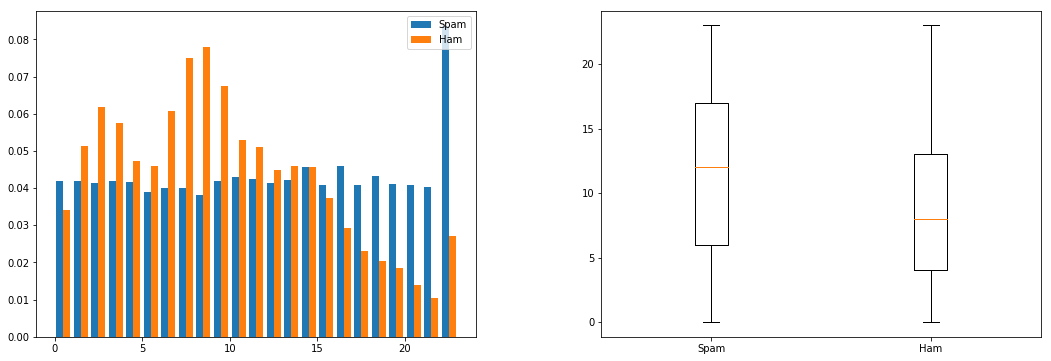

In [15]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2:4])

histPlt.hist(
    [
        dfMaster[dfMaster['isSpam'] == True]['hour'].dropna(), 
        dfMaster[dfMaster['isSpam'] == False]['hour']
    ], 
    np.linspace(0, dfMaster['hour'].max(), 24), 
    density = True, 
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        dfMaster[dfMaster['isSpam'] == True]['hour'].dropna(),
        dfMaster[dfMaster['isSpam'] == False]['hour']
    ), 
    labels = ('Spam', 'Ham')
)


plt.show()

## -- How many person this email was send TO 

In [16]:
#Create a count to
dfMaster['toCount'] = dfMaster['to'].str.split(',').apply(lambda x : len(x) if isinstance(x, list) else 0)

### --- Description for send to

In [17]:
dfMaster['toCount'].describe()

count    48928.000000
mean         3.165284
std         13.404586
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        595.000000
Name: toCount, dtype: float64

### --- Description for send to for more than one

In [18]:
dfMaster[dfMaster['toCount'] > 1]['toCount'].describe()

count    8038.000000
mean       14.333167
std        30.731960
min         2.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       595.000000
Name: toCount, dtype: float64

### --- Proportion direct email and group email

1       39661
2-15     7678
15+      1589
Name: toCountG2, dtype: int64


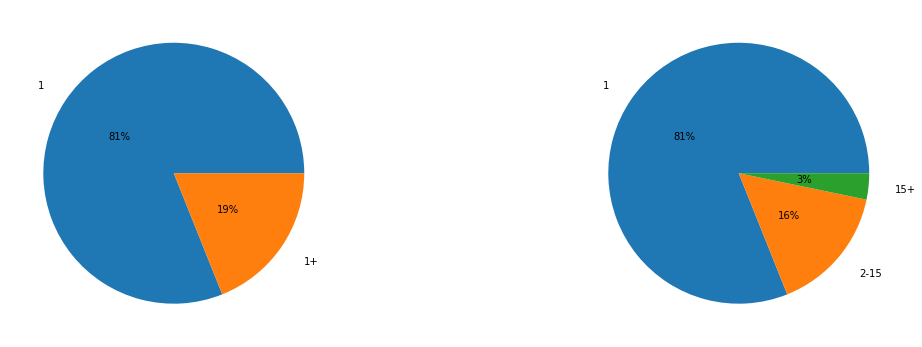

In [19]:
dfTemp = dfMaster.loc[:, ['toCount', 'isSpam']]
dfTemp['toCountG1'] = dfTemp['toCount'].apply(lambda x : '1' if x == 1 else '1+')
dfTemp['toCountG2'] = dfTemp['toCount'].apply(lambda x : '1' if x == 1 else ('15+' if x > 15 else '2-15'))

print(dfTemp['toCountG2'].value_counts())

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
pie1 = fig.add_subplot(grid[0,0:2])
pie2 = fig.add_subplot(grid[0,2:4])

pie1.pie(dfTemp['toCountG1'].value_counts(), labels=['1', '1+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

pie2.pie(dfTemp['toCountG2'].value_counts(), labels=['1', '2-15', '15+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

### --- Distribution of 'To Group' by Spam

In [20]:
dfMaster['toCountGroup'] = dfMaster['toCount'].apply(lambda x: 'Direct' if x == 1 else ('Small Group' if x < 15 else 'Big Group')) 

In [21]:
dfGroupTo = dfMaster.groupby(['toCountGroup', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()

[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
toCountGroup,,,,
Big Group,1632,63,0.962832,0.037168
Direct,11703,27958,0.295076,0.704924
Small Group,5744,1828,0.758584,0.241416


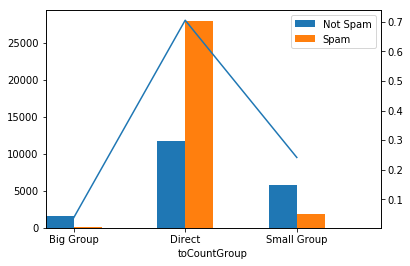

In [22]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

#.plot(kind='bar', legend=False)

## -- Compare email message lenght for ham and spam  

In [23]:
dfMaster['textLen'] = dfMaster['messageStr'].apply(lambda x : len(str(x)))

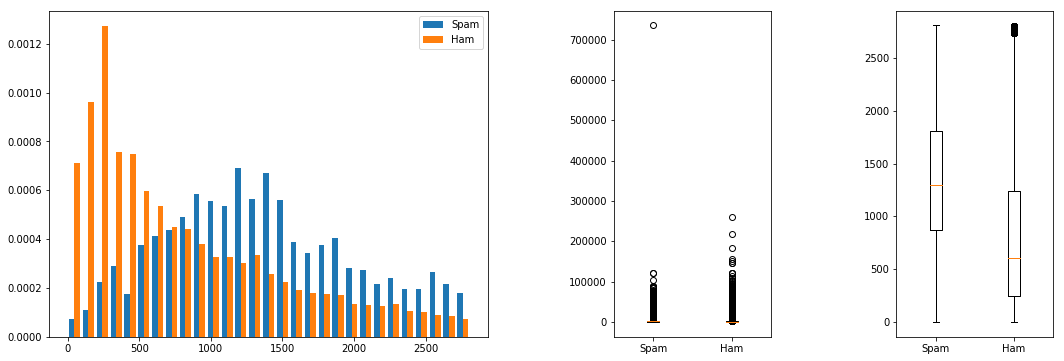

In [24]:
createPlotLenghtDist('textLen', dfMaster) 

## -- Compare clean email message lenght for ham and spam  

In [25]:
#Apply cleaning method
dfMaster['treatedMessage'] = dfMaster['messageStr'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

dfMaster['treatedTextLen'] = dfMaster['treatedMessage'].apply(lambda x : len(x)) 

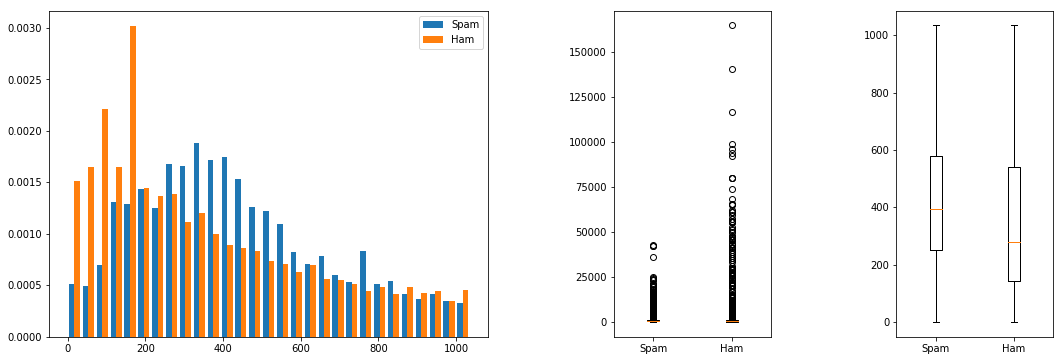

In [26]:
createPlotLenghtDist('treatedTextLen', dfMaster)

## -- Compare total words in a email message for ham and spam  

In [27]:
#Create a column with list of words
dfMaster['wordsList'] = dfMaster['treatedMessage'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedWords'] = dfMaster['wordsList'].apply(lambda x : len(x))

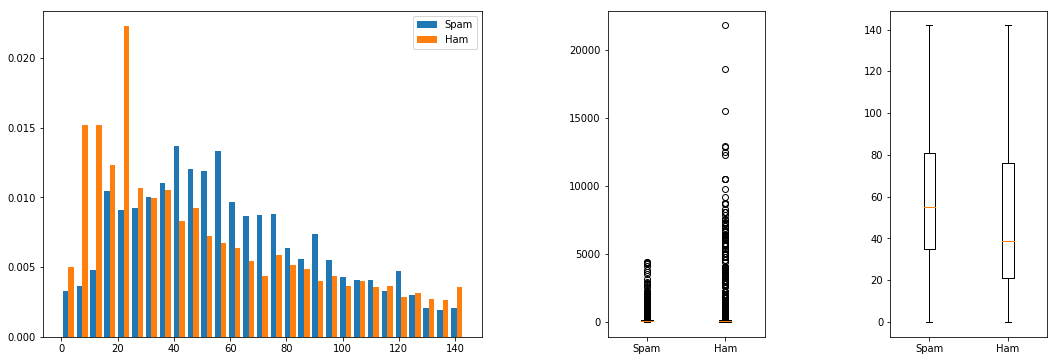

In [28]:
createPlotLenghtDist('totalTreatedWords', dfMaster)

## -- Compare total unique words in a email message for ham and spam  

In [29]:
dfMaster['uniqueWordsLen'] = dfMaster['wordsList'].apply(lambda x : len(set(x)))

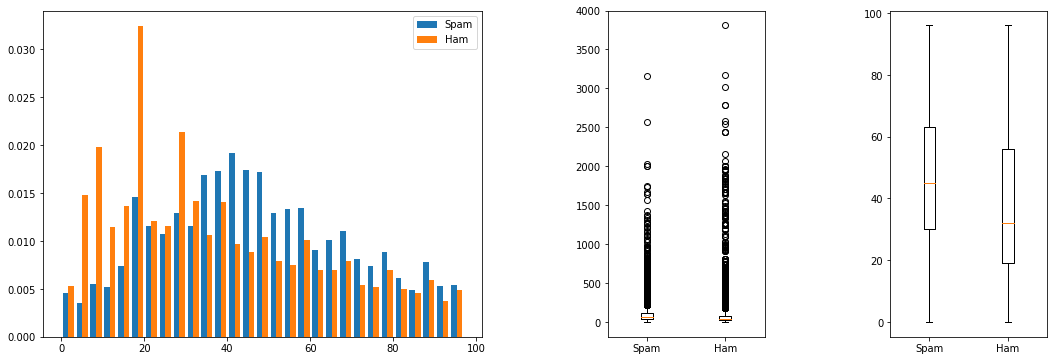

In [30]:
createPlotLenghtDist('uniqueWordsLen', dfMaster)

## Email message Words Visualization

## -- Total uniques words

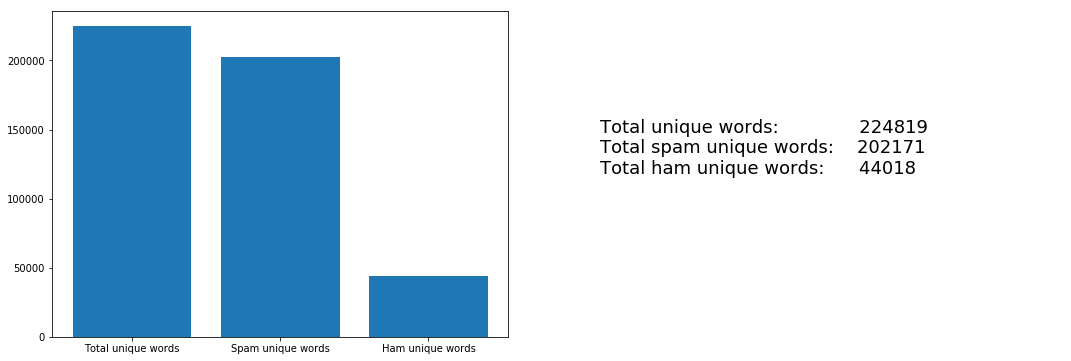

In [31]:
count = Counter(list(chain(*dfMaster["wordsList"].values)))

countSpam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == True]["wordsList"].values)))

countHam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == False]["wordsList"].values)))

totalUniqueWordsPlot(len(count), len(countSpam), len(countHam))

## -- Total Unique words with more the 100 repetitions

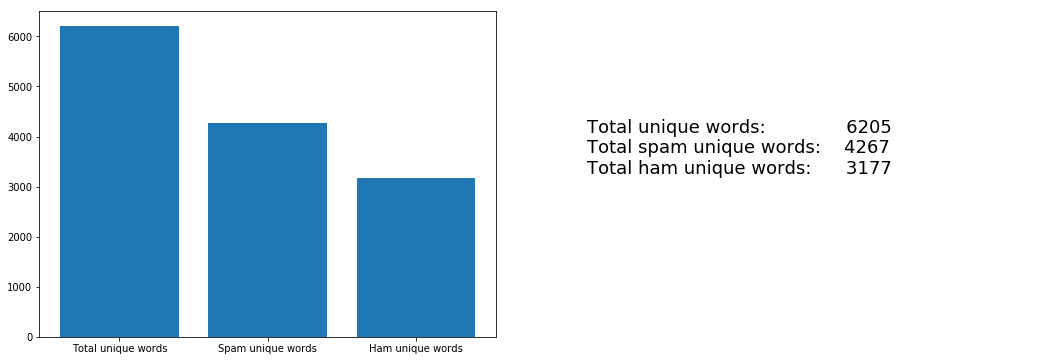

In [32]:
dfCounter = pd.DataFrame.from_dict(data = dict(count),orient='index', columns = ['freq'])

dfCounterSpam = pd.DataFrame.from_dict(data = dict(countSpam),orient='index', columns = ['freq'])

dfCounterHam = pd.DataFrame.from_dict(data = dict(countHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfCounter[dfCounter['freq'] > 100]),
    len(dfCounterSpam[dfCounterSpam['freq'] > 100]),
    len(dfCounterHam[dfCounterHam['freq'] > 100]))


## -- 20 Most common words

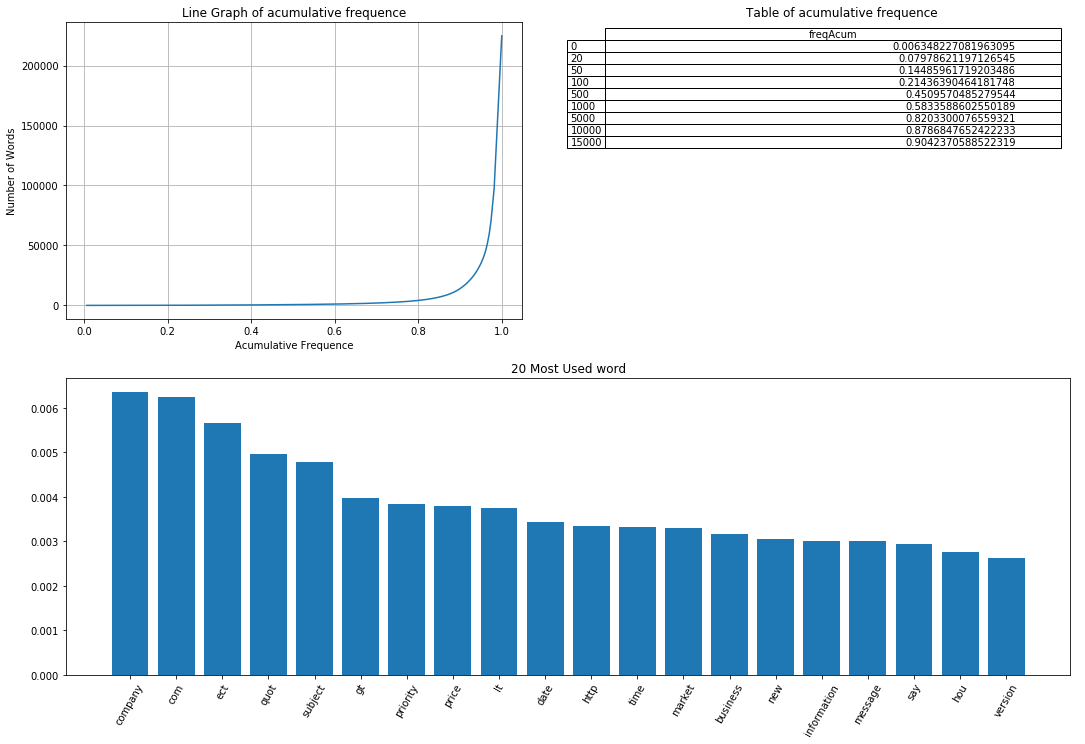

In [33]:
plot20MostWord(count)

## -- 20 Most common words on Spam emails

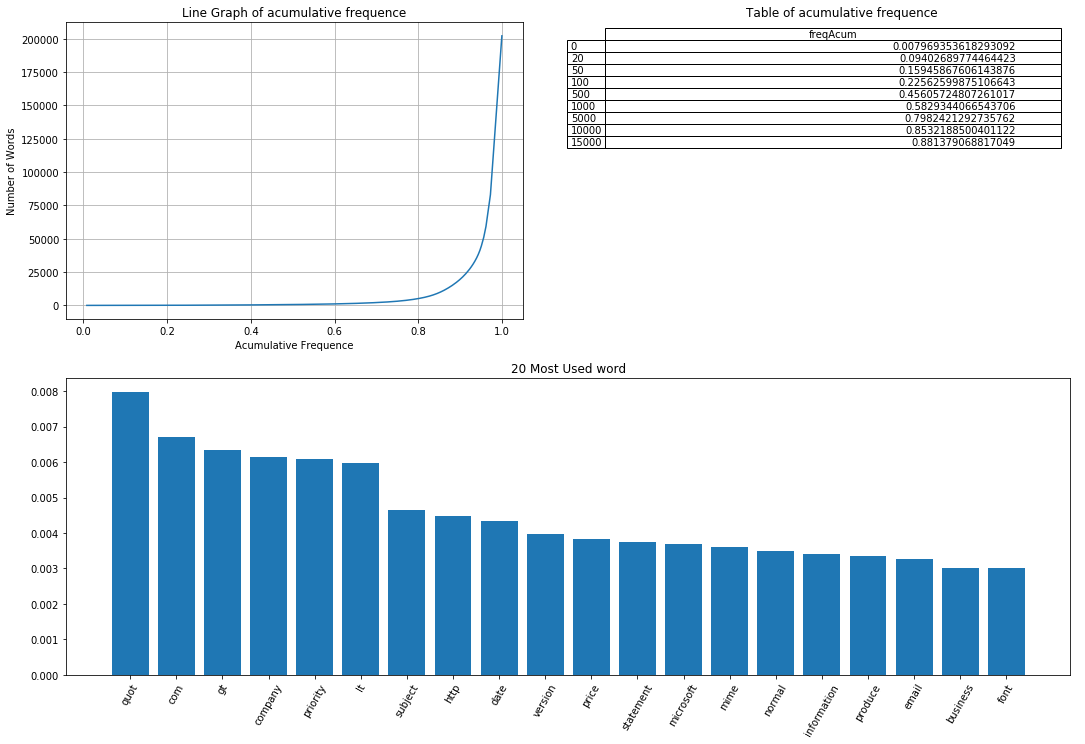

In [34]:
plot20MostWord(countSpam)

## -- 20 Most common words on Ham emails

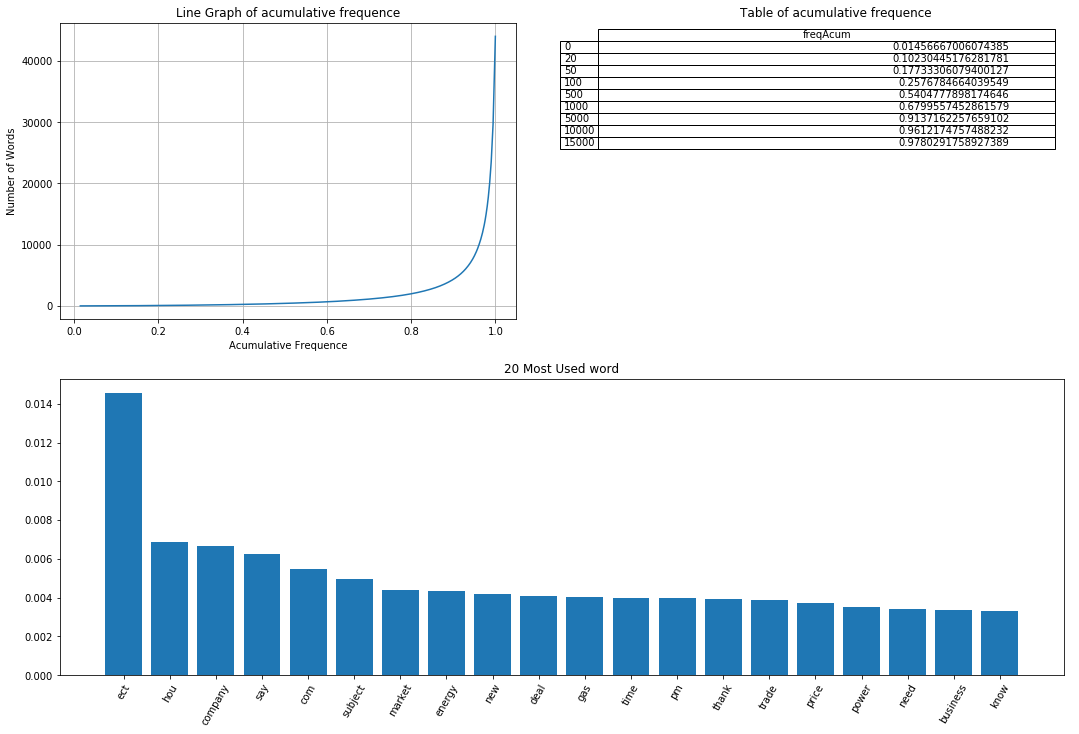

In [35]:
plot20MostWord(countHam)

## Calculate word frequence for subject

## -- Compare email subject lenght for ham and spam

In [36]:
dfMaster['subLen'] = dfMaster['subject'].apply(lambda x : len(str(x)))

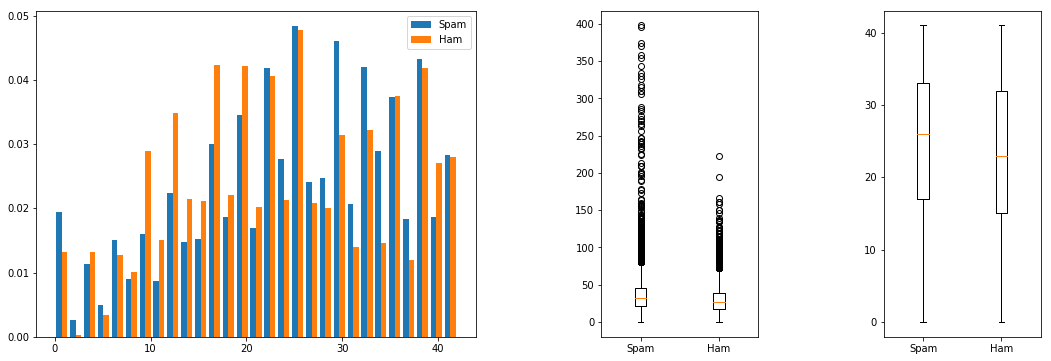

In [37]:
createPlotLenghtDist('subLen', dfMaster)

## -- Compare clean email subject lenght for ham and spam  

In [65]:
#Apply cleaning method
dfMaster['treatedSub'] = dfMaster['subject'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedSub'] = dfMaster['treatedSub'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedSub'] = dfMaster['treatedSub'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

dfMaster['treatedLen'] = dfMaster['treatedSub'].apply(lambda x : len(x))

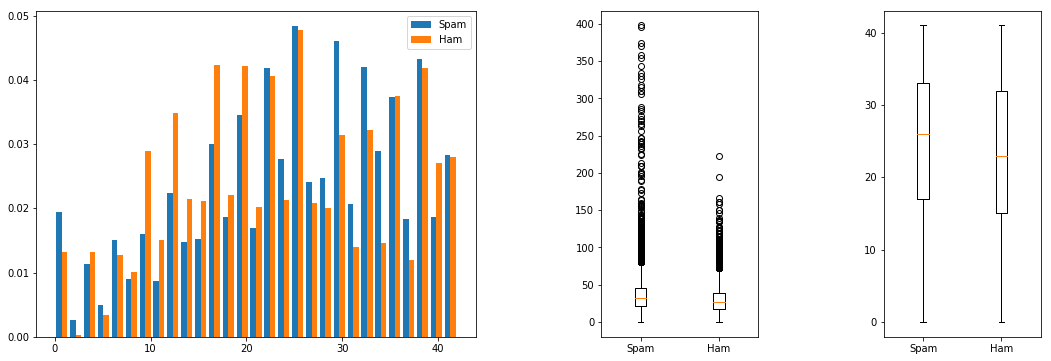

In [66]:
createPlotLenghtDist('treatedSubLen', dfMaster)

## -- Compare total words in a email subject for ham and spam  

In [67]:
#Create a column with list of words
dfMaster['subWordsList'] = dfMaster['treatedSub'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedSubWords'] = dfMaster['subWordsList'].apply(lambda x : len(x))

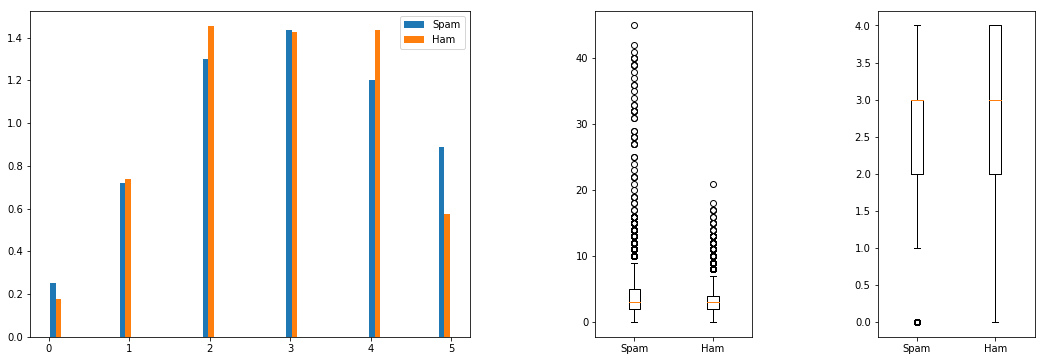

In [68]:
createPlotLenghtDist('totalTreatedSubWords', dfMaster)

## -- Compare total unique words in a email subject for ham and spam  

In [69]:
dfMaster['uniqueSubWordsLen'] = dfMaster['subWordsList'].apply(lambda x : len(set(x)))

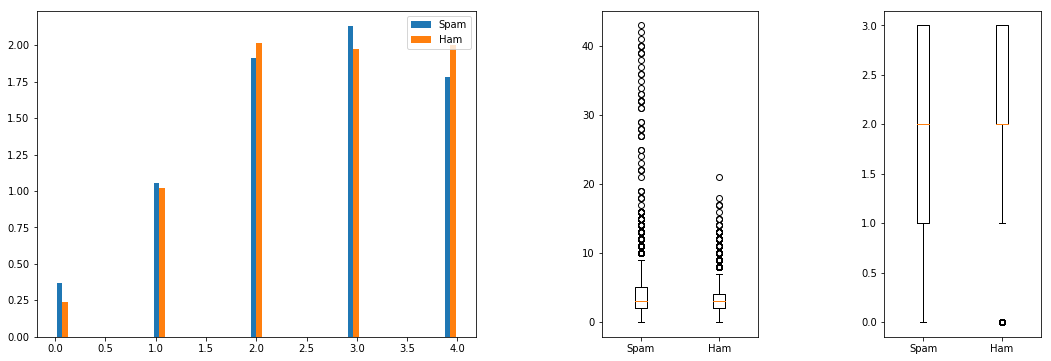

In [70]:
createPlotLenghtDist('uniqueSubWordsLen', dfMaster)

## Email Subject Words Visualization

## -- Total uniques words

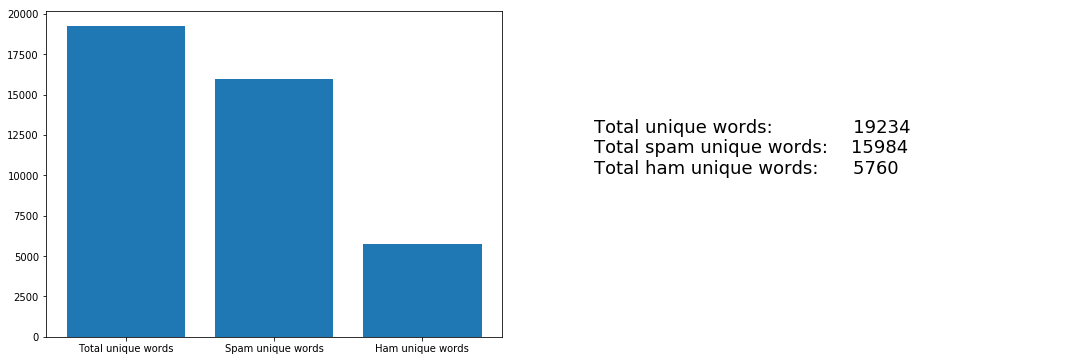

In [71]:
subCount = Counter(list(chain(*dfMaster["subWordsList"].values)))

subCountSpam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == True]["subWordsList"].values)))

subCountHam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == False]["subWordsList"].values)))

totalUniqueWordsPlot(len(subCount), len(subCountSpam), len(subCountHam))

## -- Total Unique words with more the 100 repetitions

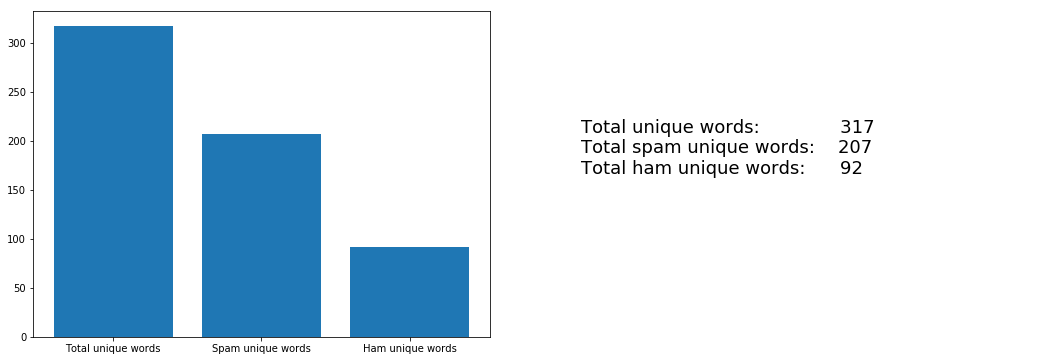

In [72]:
dfSubCounter = pd.DataFrame.from_dict(data = dict(subCount),orient='index', columns = ['freq'])

dfSubCounterSpam = pd.DataFrame.from_dict(data = dict(subCountSpam),orient='index', columns = ['freq'])

dfSubCounterHam = pd.DataFrame.from_dict(data = dict(subCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfSubCounter[dfSubCounter['freq'] > 100]),
    len(dfSubCounterSpam[dfSubCounterSpam['freq'] > 100]),
    len(dfSubCounterHam[dfSubCounterHam['freq'] > 100]))

## -- 20 Most common words


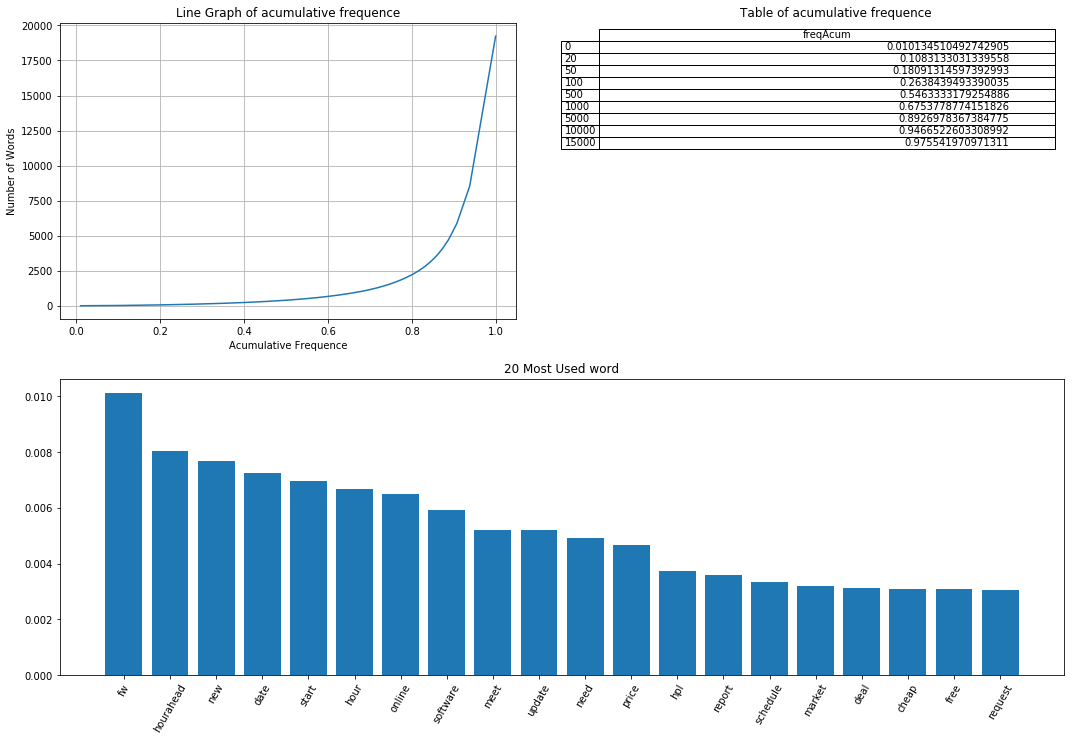

In [73]:
plot20MostWord(subCount)

## -- 20 Most common words on Spam emails

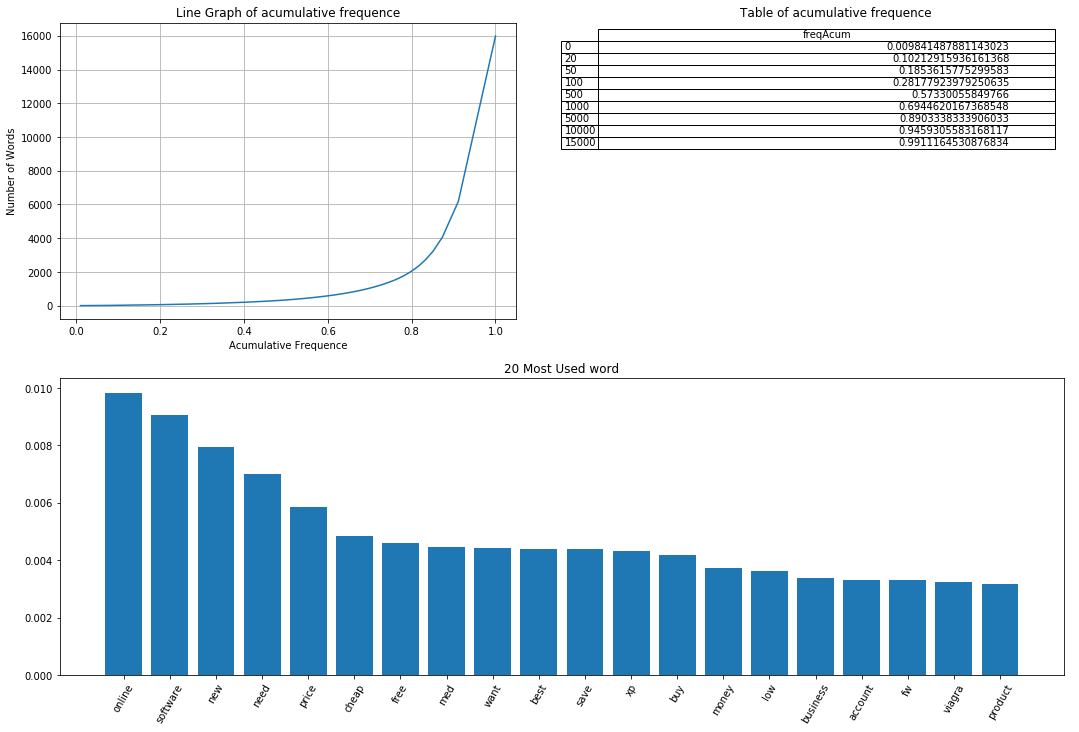

In [74]:
plot20MostWord(subCountSpam)

## -- 20 Most common words on Ham emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


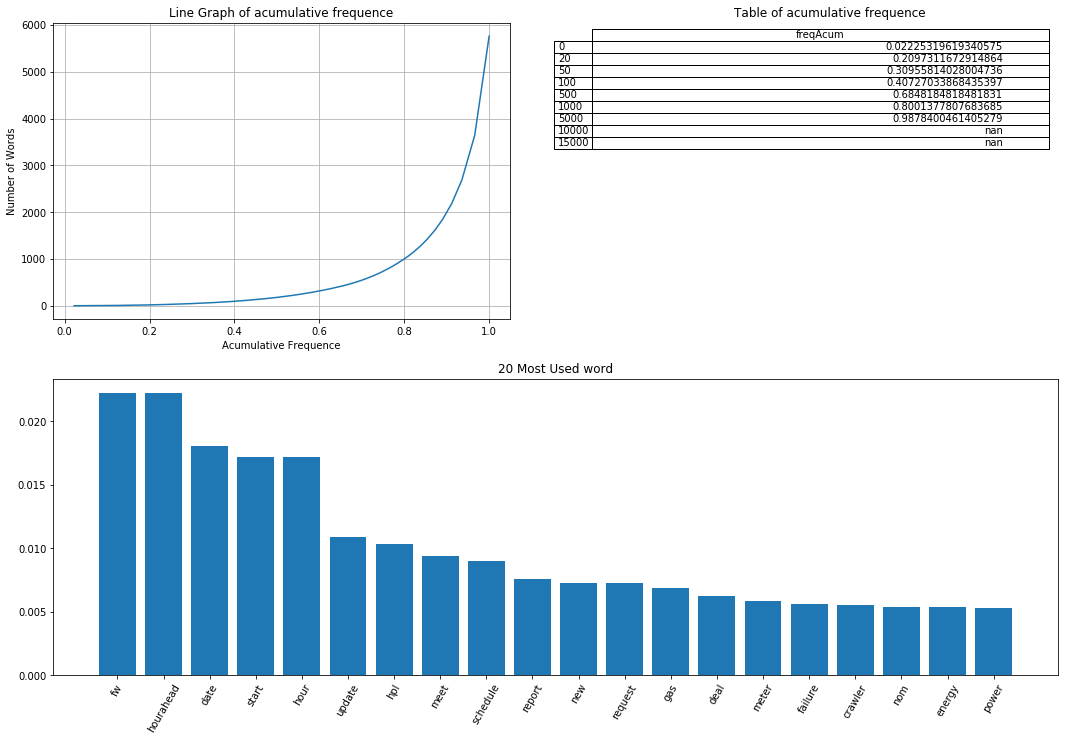

In [75]:
plot20MostWord(subCountHam)

In [78]:
dfMaster['containRE'] = dfMaster['subject'].str.contains("re")
dfMaster['containFW'] = dfMaster['subject'].str.contains("fw")


In [ ]:
dfMaster[dfMaster['containRE'] == True] 

In [49]:
stop * here

NameError: name 'here' is not defined

In [ ]:
tempStr = 'a b c44 66d e5e '

clean = re.compile('[0-9]')
tex = re.sub(clean, " ", tempStr)

print(tex)



In [ ]:
tempSet = sorted(set(list(chain(*df[df['isSpam'] == True]["wordsList"].values))))


print(tempSet)

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(tempSet)

print(misspelled)

In [ ]:
lem = WordNetLemmatizer()
words = lem.lemmatize('accommodations')

words

## Modeling

### Spliting prepare data set for modeling 

In [ ]:
#print(text.ENGLISH_STOP_WORDS)

print(type(text.ENGLISH_STOP_WORDS))



In [ ]:
l = list(chain(*df["wordsList"].values))

l = set(filter(lambda k : len(k) == 1, l))

l

In [ ]:

#Apply cleaning method
dfMaster['treatedMessage'] = dfMaster['messageStr'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Create a column with list of words
dfMaster['wordsList'] = dfMaster['treatedMessage'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedWords'] = dfMaster['wordsList'].apply(lambda x : len(x))
#dfMaster['treatedTextLen'] = dfMaster['treatedMessage'].apply(lambda x : len(x))
#dfMaster['textLen'] = dfMaster['messageStr'].apply(lambda x : len(str(x)))
dfMaster['uniqueWordsLen'] = dfMaster['wordsList'].apply(lambda x : len(set(x)))


#Convert Date to a date time object
#dfMaster['date'] = dfMaster['date'].apply(lambda x : str(x)).apply(lambda x : None if x == 'nan' else datetime.datetime.strptime(x, '%a, %d %b %Y %H:%M:%S %z'))

#Create a Hour Column
#dfMaster['hour'] = dfMaster['date'].apply(lambda x : None if x == None else x.hour)

#Create a count to
#dfMaster['toCount'] = dfMaster['to'].str.split(',').apply(lambda x : len(x) if isinstance(x, list) else 0)

dfMaster.head()

In [ ]:
fig = plt.figure(figsize = (16,12))
grid = plt.GridSpec(2,4, wspace =0.3, hspace =0.5)
pieMsg = fig.add_subplot(grid[0,0:3])
barNonNull = fig.add_subplot(grid[1,0:3])
barNull = fig.add_subplot(grid[0:2,3])


pieMsg.pie([len(dfMaster[dfMaster['messageStr'].notnull()]), len(dfMaster[dfMaster['messageStr'].isnull()])], 
        labels=['Non Null', 'Null'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)



barAll.bar(
    dfMaster['messageType'].unique(), 
    dfMaster['messageType'].value_counts(), 
    align='center'
)
barAll.set_title('All emails')

barNonNull.bar(
    dfMaster[dfMaster['messageStr'].notnull()]['messageType'].unique(), 
    dfMaster[dfMaster['messageStr'].notnull()]['messageType'].value_counts(), 
    align='center'
)

barNonNull.set_title('Non null meassages')

barNull.bar(
    dfMaster[dfMaster['messageStr'].isnull()]['messageType'].unique(), 
    dfMaster[dfMaster['messageStr'].isnull()]['messageType'].value_counts(), 
    align='center'
)

barNull.set_title('Null meassages')

fig.text(0.5, 0.04, 'Email Type', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Emails', va='center', rotation='vertical', fontsize=15)

plt.show()

In [ ]:
dfWordsG = pd.DataFrame(list(dict(count).items()))
dfWordsG.columns = ['word', 'occur'] 
totalOcurrG = dfWordsG['occur'].sum()
dfWordsG['freq'] = dfWordsG['occur'] / totalOcurrG  
dfWordsG = dfWordsG.sort_values(by='freq', ascending=False)
dfWordsG = dfWordsG.reset_index(drop=True)
dfWordsG['freqAcum'] = dfWordsG['freq'].cumsum()

dfSpamWordsG = pd.DataFrame(list(dict(countSpam).items()))
dfSpamWordsG.columns = ['word', 'occur'] 
totalSpamOcurrG = dfSpamWordsG['occur'].sum()
dfSpamWordsG['freq'] = dfSpamWordsG['occur'] / totalOcurrG  
dfSpamWordsG = dfSpamWordsG.sort_values(by='freq', ascending=False)
dfSpamWordsG = dfSpamWordsG.reset_index(drop=True)
dfSpamWordsG['freqAcum'] = dfSpamWordsG['freq'].cumsum()

dfHamWordsG = pd.DataFrame(list(dict(countHam).items()))
dfHamWordsG.columns = ['word', 'occur'] 
totalHamOcurrG = dfHamWordsG['occur'].sum()
dfHamWordsG['freq'] = dfHamWordsG['occur'] / totalOcurrG  
dfHamWordsG = dfHamWordsG.sort_values(by='freq', ascending=False)
dfHamWordsG = dfHamWordsG.reset_index(drop=True)
dfHamWordsG['freqAcum'] = dfHamWordsG['freq'].cumsum()

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,3, wspace =0.2)
pltTotal = fig.add_subplot(grid[0,0])
pltSpam = fig.add_subplot(grid[0,1])
pltHam = fig.add_subplot(grid[0,2])

pltTotal.plot(dfWords['freqAcum'], range(len(dfWordsG)))
pltTotal.set_ylabel('Total Words')
pltTotal.set_xlabel('Acumulative Frequence')
pltTotal.set_title('All Words')
pltTotal.grid(True)

pltSpam.plot(dfSpamWords['freqAcum'], range(len(dfSpamWordsG)))
pltSpam.set_ylabel('Total Spam Words')
pltSpam.set_xlabel('Acumulative Frequence')
pltSpam.set_title('Spam Words')
pltSpam.grid(True)

pltHam.plot(dfHamWords['freqAcum'], range(len(dfHamWordsG)))
pltHam.set_ylabel('Total Ham Words')
pltHam.set_xlabel('Acumulative Frequence')
pltHam.set_title('Ham Words')
pltHam.grid(True)


fig2 = plt.figure(figsize = (18,6))
grid2 = plt.GridSpec(1,6, wspace =0.4)

pltTotalTableG = fig2.add_subplot(grid2[0,0:2])
pltSpamTableG = fig2.add_subplot(grid2[0,2:4])
pltHamTableG = fig2.add_subplot(grid2[0,4:6])

dfTWordG = dfWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTotalTableG.table(cellText=dfTWordG.values, rowLabels= dfTWordG.index, colLabels = dfTWordG.columns, loc='best')
pltTotalTableG.axis('off')

dfSWordG = dfSpamWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltSpamTableG.table(cellText=dfSWordG.values, rowLabels= dfSWordG.index, colLabels = dfSWordG.columns, loc='best')
pltSpamTableG.axis('off')

dfHWordG = dfHamWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltHamTableG.table(cellText=dfHWordG.values, rowLabels= dfHWordG.index, colLabels = dfHWordG.columns, loc='best')
pltHamTableG.axis('off')


plt.show()


In [ ]:
patternStop = re.compile(r'\b(' + r'|'.join(text.ENGLISH_STOP_WORDS) + r')\b\s*')
text = patternStop.sub(' ', text)



In [ ]:
plt.pie([len(dfMaster[dfMaster['messageStr'].notnull()]), len(dfMaster[dfMaster['messageStr'].isnull()])], 
        labels=['Non Null', 'Null'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)



In [ ]:
txt.ENGLISH_STOP_WORDS